In [4]:
import os
import pydicom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define dataset path
dataset_path = ""  # Update with your dataset path

In [6]:
# Function to load and preprocess DICOM images
def load_dicom_images(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)
    class_dict = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        for file in os.listdir(class_folder):
            if file.endswith(".dcm"):  # Process only DICOM files
                dicom_path = os.path.join(class_folder, file)
                dicom_data = pydicom.dcmread(dicom_path)
                img = dicom_data.pixel_array  # Extract pixel data
                img = img / np.max(img)  # Normalize pixel values (0-1)
                img = np.expand_dims(img, axis=-1)  # Add channel dimension
                images.append(img)
                labels.append(class_dict[class_name])
    
    return np.array(images), np.array(labels), class_names

In [7]:
# Load dataset
X, y, class_names = load_dicom_images(dataset_path)

In [8]:
# Split into train & test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expand dimensions for CNN
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [11]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

In [32]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

Epoch 1/10
13/13 [==============================] - 113s 7s/step - loss: 4.6150 - accuracy: 0.5845 - val_loss: 0.3885 - val_accuracy: 0.8654
Epoch 2/10
13/13 [==============================] - 87s 7s/step - loss: 6.8532 - accuracy: 0.7826 - val_loss: 0.7485 - val_accuracy: 0.8269
Epoch 3/10
13/13 [==============================] - 87s 7s/step - loss: 34.3835 - accuracy: 0.7391 - val_loss: 0.4263 - val_accuracy: 0.8846
Epoch 4/10
13/13 [==============================] - 86s 7s/step - loss: 304.1842 - accuracy: 0.6812 - val_loss: 0.7824 - val_accuracy: 0.8846
Epoch 5/10
13/13 [==============================] - 85s 7s/step - loss: 17.1762 - accuracy: 0.8551 - val_loss: 0.4603 - val_accuracy: 0.8077
Epoch 6/10
13/13 [==============================] - 85s 7s/step - loss: 3.1752 - accuracy: 0.8406 - val_loss: 0.2044 - val_accuracy: 0.9231
Epoch 7/10
13/13 [==============================] - 86s 7s/step - loss: 2.4098 - accuracy: 0.8647 - val_loss: 0.1438 - val_accuracy: 0.9423
Epoch 8/10
13/1

In [34]:
# # Train model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 [==============================] - 4s 2s/step - loss: 0.0961 - accuracy: 0.9423
Test Accuracy: 94.23%


In [35]:
# Save the trained model
model.save("disease_prediction_model.h5")

C:\Users\DFELL\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# from tensorflow.keras.models import load_model

# Function to load the saved model
def load_saved_model():
    return load_model("disease_prediction_model.h5")

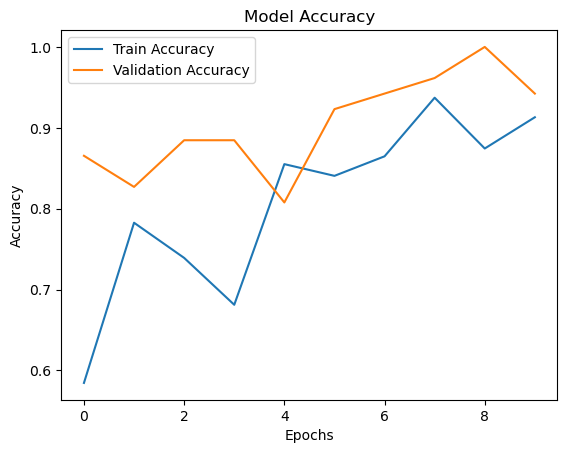

In [37]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

1/1 [==============================] - 1s 750ms/step
Predicted Disease: tumor (100.00%)


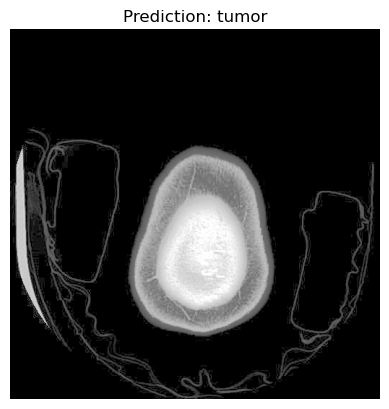

In [49]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Function to preprocess DICOM images
def preprocess_dicom(dicom_path, target_size=(512, 512)):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array.astype(np.float32)  # Convert to float
    
    # Normalize image to 0-255 range for uint8 conversion
    img = (img - img.min()) / (img.max() - img.min()) * 255.0
    img = img.astype(np.uint8)  # Convert to uint8

    # Ensure it's grayscale (remove color channels if any)
    if len(img.shape) == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization for contrast enhancement
    img = cv2.equalizeHist(img)

    # Resize to match model input size (512x512)
    img = cv2.resize(img, target_size)

    # Normalize to [0,1] for CNN
    img = img / 255.0

    # Ensure correct shape: (batch_size, height, width, channels)
    img = np.expand_dims(img, axis=-1)  # Add grayscale channel (1)
    img = np.expand_dims(img, axis=0)   # Add batch dimension (None, 512, 512, 1)

    return img

# Function to test the model with a new DICOM file
def predict_disease(dicom_path):
    model = load_model("disease_prediction_model.h5")  # Load trained model
    img = preprocess_dicom(dicom_path)  # Preprocess the image
    
    # Make prediction
    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    # Display the results
    print(f"Predicted Disease: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

# Example usage (update with actual DICOM file path)
predict_disease("76.dcm")


1/1 [==============================] - 0s 444ms/step
Predicted Disease: Tumor (100.00%)


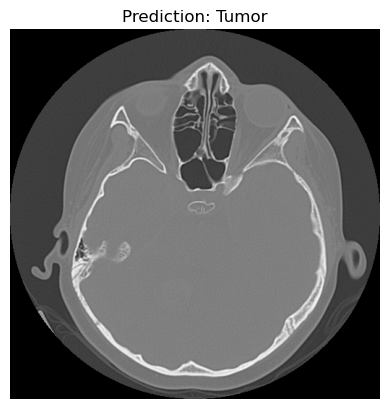

In [3]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Function to test the model with a new DICOM file
# Function to load the saved model
def load_saved_model():
    return load_model("disease_prediction_model.h5")

def predict_disease(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    img = dicom_data.pixel_array
    img = img / np.max(img)  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Expand batch dimension
    
    model=load_saved_model()
    prediction = model.predict(img)
    class_names = ["Aneurysm", "Cancer", "Tumor"]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    print(f"Predicted Disease: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

# Example usage (update with actual DICOM file path)
predict_disease("22.dcm")

2/2 [==============================] - 3s 879ms/step


C:\Users\DFELL\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


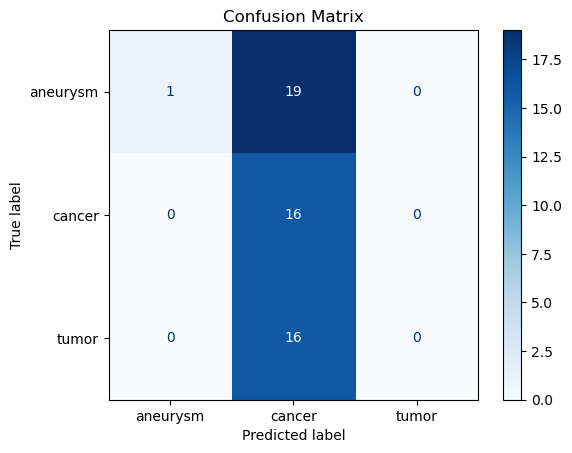

Precision: 0.4811
Recall: 0.3269
F1 Score: 0.1836
Dice Score: 0.1910


In [14]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = np.argmax(model.predict(X_test), axis=1)
# Calculate evaluation metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Dice score function
def dice_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    dice_scores = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fp = sum(cm[:, i]) - tp
        fn = sum(cm[i, :]) - tp
        dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        dice_scores.append(dice)
    return np.mean(dice_scores)

dice = dice_score(y_test, y_pred)

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Dice Score: {dice:.4f}")